In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import scipy.io as sio

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(n_inputs, 16)
        self.act1 = nn.ReLU()
        # second hidden layer
        self.hidden2 = nn.Linear(16, 32)
        self.act2 = nn.ReLU()
        # third hidden layer
        self.hidden3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        # output layer
        self.hidden4 = nn.Linear(16, 1)
        self.act4 = nn.Sigmoid()
 
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

In [3]:
def load_model(experiment_path, n_inputs):
    # extract model from experiment
    torch_models = [file for file in os.listdir(experiment_path) if file.endswith('.pt')]
    if len(torch_models) < 1: 
        print('No models found in experiment. Aborting ...')
        sys.exit()
    elif len(torch_models) > 1:
        print('Multiple models in experiment. Aborting ...')
        sys.exit()
    else:
        model_path = experiment_path + '/' + torch_models[0]

    # loading model
    model = Net(n_inputs=n_inputs)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [4]:
def read_mat_file(file):
    df = pd.DataFrame()
    columns = ['TimeStamp', 'Voltage', 'Current', 'Ah', 'Wh', 'Power', 'Battery_Temp_degC', 'Time', 'Chamber_Temp_degC']
    for col in columns:
       df[col] = pd.Series(file['meas'][0][0][col].flatten())
    return df

In [5]:
def test_model(model):

    # Test all Drive cycles
    MAE_temp = {}
    AEs, temps, socs = [], [], []
    for temp in all_temperatures:
        panasonic_dir = panasonic + f"//{temp}" + "//Drive cycles"
        panasonic_files = [f for f in os.listdir(panasonic_dir) if f not in dropped]
        labels = [label for file in panasonic_files for label in all_test_names if label in file]

        temp_MAEs, temp_y_tests, temp_y_preds, times = [], [], [], []
        for (file, label) in zip(panasonic_files, labels):           
            df_file = read_mat_file(sio.loadmat(panasonic_dir + "/" + file))
            
            # calculate SoC given a Panasonic 18650PF cell with a maximum capacity of 2.9Ah
            # Assumption: All test were started at an initial 100% SoC
            df_file["SoC"] = (2.9 + df_file['Ah'])/2.9
            
            # Moving Averages
            df_file["Voltage_MA1000"] = df_file["Voltage"].rolling(1000,min_periods=1).mean()
            df_file["Current_MA1000"] = df_file["Current"].rolling(1000,min_periods=1).mean()
            df_file["Voltage_MA400"] = df_file["Voltage"].rolling(400,min_periods=1).mean()
            df_file["Current_MA400"] = df_file["Current"].rolling(400,min_periods=1).mean()
            df_file["Voltage_MA200"] = df_file["Voltage"].rolling(200,min_periods=1).mean()
            df_file["Current_MA200"] = df_file["Current"].rolling(200,min_periods=1).mean()
            df_file["Voltage_MA100"] = df_file["Voltage"].rolling(100,min_periods=1).mean()
            df_file["Current_MA100"] = df_file["Current"].rolling(100,min_periods=1).mean()
            df_file["Voltage_MA50"] = df_file["Voltage"].rolling(50,min_periods=1).mean()
            df_file["Current_MA50"] = df_file["Current"].rolling(50,min_periods=1).mean()
            df_file["Voltage_MA10"] = df_file["Voltage"].rolling(10,min_periods=1).mean()
            df_file["Current_MA10"] = df_file["Current"].rolling(10,min_periods=1).mean()

            # Power
            df_file["Power"] = df_file["Voltage"]*df_file["Current"]

            # Derivatives
            # df_file["Voltage_grad"] = symmetric_derivative(df_file["Voltage"], df_file["Time"])
            # df_file["Current_grad"] = symmetric_derivative(df_file["Current"], df_file["Time"])
            # df_file["Battery_Temp_grad"] = symmetric_derivative(df_file["Battery_Temp_degC"], df_file["Time"])
            # df_file["Power_grad"] = symmetric_derivative(df_file["Power"], df_file["Time"])
            
            # Feature selection
            df_file = df_file.drop(['Chamber_Temp_degC'], axis=1)
            df_file.drop(df_file.tail(1).index, inplace=True)
            df_file.drop(df_file.head(1).index, inplace=True)
            time_from_start = np.array(df_file['Time']) - df_file['Time'].values[0]
            df_file = df_file[features + target]

            # Normalization
            with open(f"..//data//{config['norm_basis']}", 'r') as f:
                norm_basis = json.load(f)                    
            for feature in norm_basis.keys():
                minmax = norm_basis[feature]
                df_file[feature] = (df_file[feature] - minmax[0])/(minmax[1] - minmax[0])           
            
            # Evaluate performance against model
            X_test = torch.tensor(df_file.drop(columns=['SoC']).values, dtype=torch.float32)
            y_test = torch.tensor(df_file['SoC'].values, dtype=torch.float32).reshape(-1, 1)
            
            y_pred = model(X_test)

            # Calculate performance
            MAE = torch.mean(torch.abs(y_test - y_pred))
            temp_MAEs += [float(MAE)]
            temp_y_tests += [y_test.cpu().detach().numpy()]
            temp_y_preds += [y_pred.cpu().detach().numpy()]
            times += [time_from_start]
        
        
        MAE_temp[temp] = round(np.mean(temp_MAEs)*100, 3)
        
        # include extra values
        temps += list(df_file["Battery_Temp_degC"].values)
        socs += list(df_file['SoC'].values)
        AEs += list(torch.abs(y_test - y_pred).cpu().detach().numpy())


    return pd.DataFrame({"temp": temps, "SoC": socs, "AE": list(map(lambda x: x[0], AEs))})

In [6]:
EXPERIMENT_TOTEST = "panasonic-hyper-0.0.4"
MODEL = "trial_d1265_00042"

In [7]:
hyper_folder = glob.glob(f"..//logs//{EXPERIMENT_TOTEST}//train_*")[0]
trial_folder = f"{hyper_folder}//{MODEL}"

features = ['Voltage', 'Current', 'Power', 'Battery_Temp_degC', 'Voltage_MA1000', 'Current_MA1000', 'Voltage_MA400', 'Current_MA400', 'Voltage_MA200', 'Current_MA200', 'Voltage_MA100', 'Current_MA100', 'Voltage_MA50', 'Current_MA50', 'Voltage_MA10', 'Current_MA10']
# , 'Voltage_grad', 'Current_grad', 'Battery_Temp_grad', 'Power_grad'
target = ['SoC']
with open(f"..//logs//{EXPERIMENT_TOTEST}//config.json", 'r') as f:
    config = json.load(f)

In [8]:
# Panasonic Data
panasonic = "..//data//Panasonic//Panasonic 18650PF Data"
all_temperatures = ["0degC", "-10degC", "-20degC", "10degC", "25degC"]
all_test_names = ["HWFET", "LA92", "UDDS", "US06", "Cycle_1", "Cycle_2", "Cycle_3", "Cycle_4", "NN", "HWFTa", "HWFTb"]

# dropped files are just concats of previous measurements
dropped = [
    '06-01-17_10.36 0degC_LA92_NN_Pan18650PF.mat',
    '03-27-17_09.06 10degC_US06_HWFET_UDDS_LA92_NN_Pan18650PF.mat',
    '06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pan18650PF.mat',
    '06-23-17_23.35 n20degC_HWFET_UDDS_LA92_NN_Pan18650PF.mat',
]

In [9]:
model = load_model(experiment_path=trial_folder, n_inputs=len(features))

In [10]:
test_results = test_model(model=model)

In [11]:
test_results

,temp,SoC,AE
0,0.393975,1.000000,0.002481
1,0.393975,1.000000,0.002431
2,0.393975,1.000000,0.002420
3,0.393975,0.999997,0.002428
4,0.393975,0.999997,0.002442
...,...,...,...
423555,0.897551,0.120821,0.001439
423556,0.897342,0.120821,0.001395
423557,0.897342,0.120821,0.001382
423558,0.897342,0.120821,0.001368


In [12]:
# Denormalize temperature
with open(f"..//data//{config['norm_basis']}", 'r') as f:
    norm_basis = json.load(f) 

In [13]:
minmax = norm_basis['Battery_Temp_degC']
test_results['temp'] = test_results['temp']*(minmax[1] - minmax[0]) + minmax[0]
test_results

,temp,SoC,AE
0,0.550856,1.000000,0.002481
1,0.550856,1.000000,0.002431
2,0.550856,1.000000,0.002420
3,0.550856,0.999997,0.002428
4,0.550856,0.999997,0.002442
...,...,...,...
423555,27.491260,0.120821,0.001439
423556,27.480050,0.120821,0.001395
423557,27.480050,0.120821,0.001382
423558,27.480050,0.120821,0.001368


In [14]:
def plot_seasonality(test_results):
    xi = times   
    yi = np.linspace(1, np.shape(matrix)[1], np.shape(matrix)[1]).astype(int)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    
    ax.contour(xi, yi, np.transpose(matrix), levels=range(0, 50), linewidths=0., colors='k')
                
    cntr1 = ax.contourf(xi, yi, np.transpose(matrix), levels=np.shape(matrix)[1], cmap="RdBu_r")
    fig.colorbar(cntr1, ax=ax, shrink=1, label="Electricity Consumption [kW]")
    
    ax.set_title("Consumption")
    ax.set_ylabel("Week", fontsize=10)
    ax.set_xlabel("time", fontsize=10)
    
    # xticks
    weekday = ["Mo", "Tu", "We", "Thu", "Fri", "Sa", "Su"]
    week = [datetime(year=2000, month=1, day=3, minute=0) + timedelta(minutes=i*15) for i in range(quarters_in_week)]
    custom_ticks = range(0, quarters_in_week, 48)    
    timestamps = [f"{weekday[week[t].weekday()]}\n{week[t].hour}:{week[t].minute}" for t in custom_ticks]    
    ax.set_xticklabels(timestamps)
    ax.set_xticks(custom_ticks)
    
    # y_ticks
    r = [datetime.strptime(f"2012-W{i}" + "-1", "%Y-W%W-%w").month - 1 for i in range(1, 52+1)]
    months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "okt", "nov", "dec"]
    custom_yticks = range(1, 1+np.shape(matrix)[1], 2)   
    custom_ylabels = [months[r[(first_week+w-2)%52]] for w in custom_yticks]    
    ax.set_yticklabels(custom_ylabels)
    ax.set_yticks(custom_yticks)
    
    plt.show()

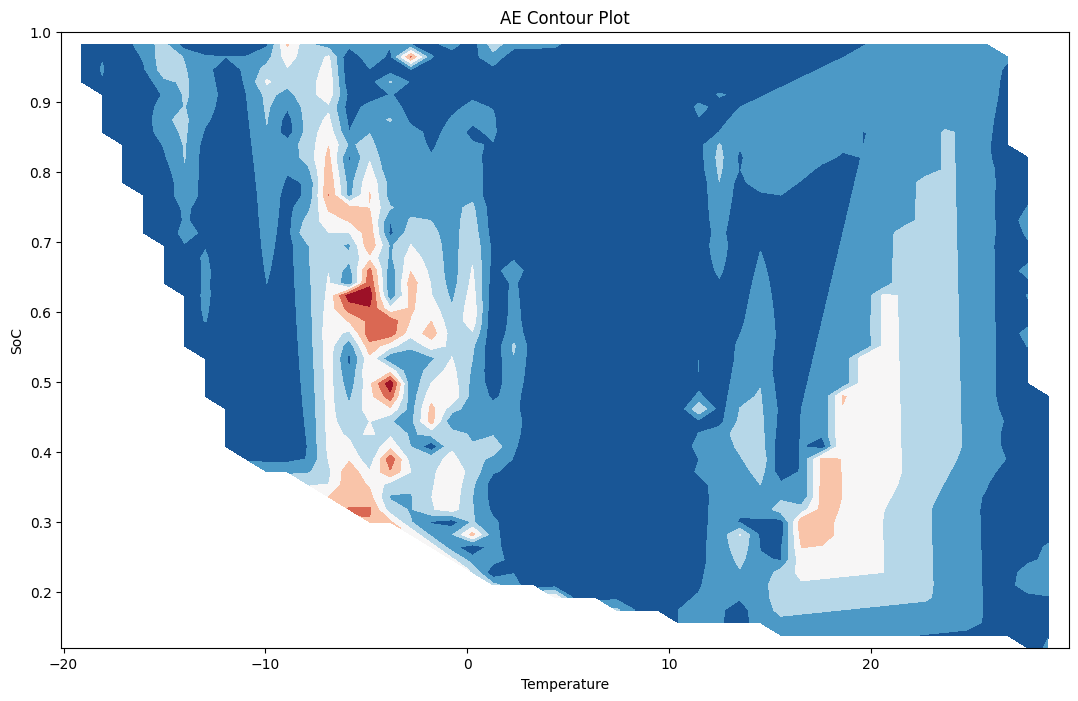

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


x = test_results["temp"].values
y = test_results["SoC"].values
z = test_results["AE"].values

resolution = 50
contour_method='linear'
resolution = str(resolution)+'j'
X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
points = [[a,b] for a,b in zip(x,y)]
Z = griddata(points, z, (X, Y), method=contour_method)

fig, ax = plt.subplots(figsize=(13,8))
ax.contourf(X,Y,Z, cmap="RdBu_r")

# Adding labels and title
plt.xlabel('Temperature')
plt.ylabel('SoC')
plt.title('AE Contour Plot')

# Displaying the plot
plt.show()